In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

from datetime import datetime
import json
from collections import defaultdict

import os

from prod_slda.model import ProdSLDA
from prod_slda.data_utils import *

In [2]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
# ----- EXPERIMENT HPARAMS -----
META_FEATURES   = ['pos_bigrams','formality','emoji_task', 'casing','punc_tags', 'sentiment_task']
EXPERIMENT_NAME = '_'.join(META_FEATURES)

# ----- DATA HPARAMS -----
OUT_DIR       = '/mnt/swordfish-pool2/ndeas/prob_models/results2/' #'/burg/nlp/users/zfh2000/style_results'

DATA_SRC      = '/mnt/swordfish-pool2/ndeas/prob_models/data/enron_processed.json' #'/burg/nlp/users/zfh2000/enron_processed.json'
SPLITS_PATH   = '/mnt/swordfish-pool2/ndeas/prob_models/data/authors_splits.json' #'/burg/home/zfh2000/styletopicmodeling/scripts/authors_splits.json'
SYNTHETIC_SRC = '/mnt/swordfish-pool2/ndeas/prob_models/data/gpt_4_enron_processed.json' #'/burg/nlp/users/zfh2000/gpt_4_enron_processed.json'

BATCH_SIZE  = 128
NUM_WORKERS = 2

MAX_DF = 0.8
MIN_DF = 20

DATA_DIR_PATH = os.path.join(OUT_DIR,EXPERIMENT_NAME, f'maxdf{MAX_DF}_mindf{MIN_DF}_DATA')

# NICK: files have been uploaded here: https://drive.google.com/drive/folders/1uF9GWEGe4aqSeo2MlachAWR9bTHsJq1q?usp=sharing
# ['formality','irony', 'sentences', 'punc_tags', 'pos_bigrams', 'morph_tags', 'pos', 'casing', 'question',  'passive', 'emotion_task', 'sentiment_task', 'emoji_task']
# NICK: Unsure which of of these features we should include!

# ----- TRAINING HPARAMS -----

LR = 1e3
BETAS = (0.99, 0.999)
EPS   = 1e-8
CLIP_NORM = 10.
ADAM_ARGS = {'lr': LR, 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}

# ----- MODEL HPARAMS -----

NUM_TOPICS = 10
NUM_STYLES = 10
HIDDEN_DIM = 128
DROPOUT    = 0

THETA_PRIOR_DIST = 'gaussian'
THETA_PRIOR_LOC = 0.
THETA_PRIOR_SCALE = 1.

KAPPA_PRIOR_DIST = 'gaussian'
KAPPA_PRIOR_LOC = 0.
KAPPA_PRIOR_SCALE = 5.

STYLE_TOPIC_LINK = 'kappa_doc'

NUM_EPOCHS = 30

DEVICE = torch.device('cuda:0')

# ----- CONFIG/SAVING -----
date = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")

info = {
    'experiment_name': EXPERIMENT_NAME,
    'num_topics': NUM_TOPICS,
    'num_styles': NUM_STYLES,
    'hidden_dim': HIDDEN_DIM,
    'dropout': DROPOUT,
    'theta_prior_dist': THETA_PRIOR_DIST,
    'theta_prior_loc': THETA_PRIOR_LOC,
    'theta_prior_scale': THETA_PRIOR_SCALE,
    'kappa_prior_dist': KAPPA_PRIOR_DIST,
    'kappa_prior_loc': KAPPA_PRIOR_LOC,
    'kappa_prior_scale': KAPPA_PRIOR_SCALE,
    'style_topic_link': STYLE_TOPIC_LINK,
    'num_epochs': NUM_EPOCHS,
    'date': date,
    'lr': LR,
    'betas': BETAS,
    'eps': EPS,
    'batch_size': BATCH_SIZE,
    'clip_norm': CLIP_NORM,
    'num_workers': NUM_WORKERS,
    'device': DEVICE.type,
    'meta_features': META_FEATURES,
    'DATA_SRC': DATA_SRC,
    'SPLITS_PATH': SPLITS_PATH,
    'SYNTHETIC_SRC': SYNTHETIC_SRC,
    'MAX_DF': MAX_DF,
    'MIN_DF': MIN_DF,
}

PATH = os.path.join(OUT_DIR, EXPERIMENT_NAME, date)
os.makedirs(PATH, exist_ok=True)
with open(os.path.join(PATH, 'info.json'), 'w') as f:
    json.dump(info, f, indent=4)

# Data Setup 

## Data Preprocessing/Loading

In [4]:
if not os.path.exists(DATA_DIR_PATH):
    bows, meta_vectorized, vectorizer, raw_text, authors_json, meta_features_to_names = prepare_data(DATA_SRC,
                 SYNTHETIC_SRC,
                 SPLITS_PATH,
                 META_FEATURES,
                 DATA_DIR_PATH,
                 max_df = MAX_DF,
                 min_df = MIN_DF)
else:
    print(f"LOADING FROM {DATA_DIR_PATH}")
    
    bows, meta_vectorized, vectorizer, raw_text, authors_json, meta_features_to_names = load_data(DATA_DIR_PATH)   

LOADING FROM /mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/maxdf0.8_mindf20_DATA


In [5]:
NUM_DOCS   = bows['training'].shape[0]
VOCAB_SIZE = bows['training'].shape[1]
META_SIZE  = {k:v.shape[1] for k,v in meta_vectorized['training'].items()}
IDX_TO_TERM = {v:k for k,v in vectorizer.vocabulary_.items()}

In [6]:
print(f'BOW Dims: {bows["training"].shape}')
print(f'META Dims: {META_SIZE}')

BOW Dims: (66668, 3098)
META Dims: {'casing': 3, 'emoji_task': 20, 'formality': 2, 'pos_bigrams': 324, 'punc_tags': 20, 'sentiment_task': 3}


## Dataset

In [7]:
dataset = DocMetaData(bows['training'], meta_vectorized['training'])
eval_dataset = DocMetaData(bows['holdout'], meta_vectorized['holdout'], split_halves = True)

In [8]:
dl = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)
eval_dl = DataLoader(eval_dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)

In [9]:
train_test_batch = next(iter(dl))
for k, v in train_test_batch.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print(f'\t{k1:15s}: {str(v1.shape)}')
    else:
        print(f'{k:15s}\n\t{"":15s}: {v.shape}')

bow            
	               : torch.Size([128, 3098])
meta
	casing         : torch.Size([128, 3])
	emoji_task     : torch.Size([128, 20])
	formality      : torch.Size([128, 2])
	pos_bigrams    : torch.Size([128, 324])
	punc_tags      : torch.Size([128, 20])
	sentiment_task : torch.Size([128, 3])


In [10]:
eval_test_batch = next(iter(eval_dl))
for k, v in eval_test_batch.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print(f'\t{k1:15s}: {str(v1.shape)}')
    else:
        print(f'{k:15s}\n\t{"":15s}: {v.shape}')

bow            
	               : torch.Size([128, 3098])
meta
	casing         : torch.Size([128, 3])
	emoji_task     : torch.Size([128, 20])
	formality      : torch.Size([128, 2])
	pos_bigrams    : torch.Size([128, 324])
	punc_tags      : torch.Size([128, 20])
	sentiment_task : torch.Size([128, 3])
bow_h1         
	               : torch.Size([128, 3098])
bow_h2         
	               : torch.Size([128, 3098])


# Training

## Setup

In [11]:
prod_slda = ProdSLDA(
    vocab_size = VOCAB_SIZE,
    meta_sizes  = META_SIZE,
    num_topics = NUM_TOPICS, num_styles = NUM_STYLES, 
    hidden = HIDDEN_DIM, dropout = DROPOUT, 
    theta_prior_dist = THETA_PRIOR_DIST, 
    theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = THETA_PRIOR_SCALE,
    kappa_prior_dist = KAPPA_PRIOR_DIST, 
    kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = KAPPA_PRIOR_SCALE,
    style_topic_link = STYLE_TOPIC_LINK,
).to(DEVICE)

print(prod_slda.beta_document())
print(prod_slda.beta_meta())


{'beta_topic': tensor([[-0.3162, -0.0141, -0.0655,  ..., -0.2998,  0.1398,  0.3037],
        [ 0.1387,  0.0462,  0.1879,  ...,  0.0903, -0.0471, -0.2019],
        [ 0.1306,  0.2427, -0.0186,  ..., -0.1506, -0.1263,  0.0336],
        ...,
        [ 0.2520,  0.2581, -0.0911,  ..., -0.2388, -0.0507, -0.2599],
        [ 0.0116, -0.1242, -0.1730,  ..., -0.2861, -0.1885, -0.1310],
        [ 0.1198,  0.1374,  0.1033,  ..., -0.2738,  0.2419,  0.2774]]), 'beta_style': tensor([[-0.2466,  0.1948, -0.1026,  ...,  0.0531, -0.2278, -0.2550],
        [-0.0990, -0.0106, -0.0857,  ..., -0.0218,  0.2364,  0.2871],
        [-0.2501,  0.1826,  0.0847,  ...,  0.1764, -0.2415,  0.2570],
        ...,
        [ 0.1013, -0.0648, -0.1167,  ...,  0.2904, -0.1321,  0.2530],
        [-0.0799,  0.2325,  0.2374,  ...,  0.0578,  0.1194,  0.2908],
        [ 0.1605,  0.2521, -0.0162,  ...,  0.2719, -0.0366, -0.0226]])}
{'casing': tensor([[ 0.0043,  0.2769, -0.0183],
        [-0.1474,  0.0129, -0.2563],
        [-0.2766

## Training 

In [12]:
%%capture cap --no-stderr
pyro.clear_param_store()
prod_slda.train()

In [15]:
optim = pyro.optim.ClippedAdam(ADAM_ARGS)

svi = SVI(
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    pyro.poutine.scale(prod_slda.guide, BATCH_SIZE/len(dl.dataset)),
    optim,
    loss = TraceMeanField_ELBO()
)

In [33]:
LAST_ELBOS = 5

In [ ]:
def train_epochs(prod_slda, svi, train_dl, eval_dl, num_epochs, device, last_elbos = 5):
    total_epochs = 0
    train_elbo = []
    val_elbo = []

    print("---TRAINING---")
    for epoch in range(num_epochs):

        epoch_elbo = 0.
        prod_slda.train()
        for batch in tqdm(train_dl):

            batch = batch_to_device(batch, device)

            bow = batch['bow']
            meta = batch['meta']

            epoch_elbo += svi.step(bow, meta)


        eval_elbo = 0
        prod_slda.eval()
        with torch.no_grad():
            for batch in tqdm(eval_dl):

                batch = batch_to_device(batch, device)

                bow = batch['bow']
                meta = batch['meta']

                eval_elbo += svi.evaluate_loss(bow, meta)           


        print(f'Epoch {epoch}: {epoch_elbo:.3f}')
        print(f'Epoch {epoch}: Eval: {eval_elbo:.3f}')

        train_elbo.append(epoch_elbo)
        val_elbo.append(eval_elbo)
        total_epochs +=1

        if len(val_elbo) > last_elbos:
            val_elbo_changes = [val_elbo[i-1] - val_elbo[i] for i in range(len(val_elbo) - last_elbos, len(val_elbo))]
            if np.mean(val_elbo_changes) > 0:
                print('Val ELBO diverging, stopping fitting')
                break 
                
    return train_elbo, val_elbo

In [36]:
train_elbo, val_elbo = train_epochs(prod_slda, dl, eval_dl, NUM_EPOCHS, DEVICE, last_elbos = LAST_ELBOS) 

---TRAINING---


100%|██████████| 179/179 [00:12<00:00, 13.81it/s]


Epoch 0: 13417.151
Epoch 0: Eval: 4369.970


100%|██████████| 179/179 [00:13<00:00, 13.65it/s]


Epoch 1: 13046.787
Epoch 1: Eval: 4356.735


100%|██████████| 179/179 [00:12<00:00, 14.75it/s]


Epoch 2: 13059.312
Epoch 2: Eval: 4351.744


100%|██████████| 179/179 [00:12<00:00, 13.82it/s]


Epoch 3: 12996.258
Epoch 3: Eval: 4347.538


100%|██████████| 179/179 [00:12<00:00, 14.09it/s]


Epoch 4: 12981.617
Epoch 4: Eval: 4347.076


100%|██████████| 179/179 [00:12<00:00, 14.28it/s]


Epoch 5: 12970.875
Epoch 5: Eval: 4347.399
Val ELBO diverging, stopping fitting


100%|██████████| 179/179 [00:12<00:00, 14.76it/s]


Epoch 6: 12974.009
Epoch 6: Eval: 4344.088
Val ELBO diverging, stopping fitting


100%|██████████| 179/179 [00:11<00:00, 15.44it/s]


Epoch 7: 12955.726
Epoch 7: Eval: 4341.986
Val ELBO diverging, stopping fitting


100%|██████████| 179/179 [00:12<00:00, 14.29it/s]


Epoch 8: 12952.349
Epoch 8: Eval: 4341.921
Val ELBO diverging, stopping fitting


 48%|████▊     | 86/179 [00:05<00:06, 14.47it/s]


KeyboardInterrupt: 

In [19]:
path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
prod_slda.eval()
torch.save(prod_slda, path)
print(f'Saved to {path}')

Saved to /mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-20_11_57_18/model_epoch50_6037.828990936279.pt


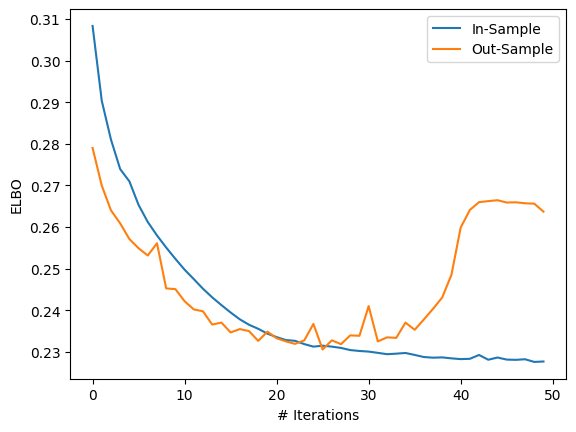

In [20]:
plt.plot(range(len(train_elbo)), [e/len(dl.dataset) for e in train_elbo], label = 'In-Sample')
plt.plot(range(len(val_elbo)), [e/len(eval_dl.dataset) for e in val_elbo], label = 'Out-Sample')

plt.legend()
plt.xlabel('# Iterations')
plt.ylabel('ELBO')

plt.savefig(os.path.join(PATH, 'loss_plot_indep.png'), dpi = 600, facecolor = None)


In [21]:
path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
prod_slda.eval()
torch.save(prod_slda, path)
print(f'Saved to {path}')

Saved to /mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-20_11_57_18/model_epoch50_6037.828990936279.pt


# Eval 

## Reconstruct Perplexity 

In [22]:
def calc_doc_perp(prod_slda, eval_dl, device, use_style = True):
    total_ce, total_count = 0., 0.
    for batch in tqdm(eval_dl):
        for key in batch.keys():
            if isinstance(batch[key], dict):
                for key2 in batch[key].keys():
                    batch[key][key2] = batch[key][key2].to(device)
            else:
                batch[key] = batch[key].to(device)

        ce, count = prod_slda.doc_reconstruct_ce(batch, use_style = use_style)
        total_ce += ce
        total_count += count
    return torch.exp(total_ce/total_count).item()

def calc_style_perp(prod_slda, eval_dl, device):
    total_ce, total_count = 0., 0.
    for batch in tqdm(eval_dl):
        for key in batch.keys():
            if isinstance(batch[key], dict):
                for key2 in batch[key].keys():
                    batch[key][key2] = batch[key][key2].to(device)
            else:
                batch[key] = batch[key].to(device)

        ce, count = prod_slda.style_reconstruct_ce(batch)
        total_ce += ce
        total_count += count
    return torch.exp(total_ce/total_count).item()

In [23]:
prod_slda = torch.load(path).to(DEVICE)

In [25]:
doc_perp      = calc_doc_perp(prod_slda, eval_dl, DEVICE)
doc_only_perp = calc_doc_perp(prod_slda, eval_dl, DEVICE, use_style = False)
style_perp    = calc_style_perp(prod_slda, eval_dl, DEVICE)

100%|██████████| 179/179 [00:12<00:00, 14.78it/s]


In [26]:
print(f'Perp           : {doc_perp:.4f}')
print(f'Perp (No Style): {doc_only_perp:.4f}')
print(f'Style Perp     : {style_perp:.4f}')

Perp           : 2498.8491
Perp (No Style): 2315.7844
Style Perp     : 57.8906


# Examine Topics 

In [29]:
def top_beta_document(model, vectorizer, top_k=20):
    betas_document = model.beta_document()
    features_to_betas = {}
    idx_to_name = {v:k for k,v in vectorizer.vocabulary_.items()}
    for feature, logits in betas_document.items():
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, top_k, dim=-1)
        
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
                
    return features_to_betas

def top_beta_meta(model, meta_feature_to_names, top_k=20):
    betas_metas = model.beta_meta()
    features_to_betas = {}
    for feature, logits in betas_metas.items():
        idx_to_name = {i:k for i,k in enumerate(meta_feature_to_names[feature])}
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, min(top_k, logits.shape[1]), dim=-1)
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
        
    return features_to_betas 

In [30]:
top_words_per_latent = top_beta_document(prod_slda, vectorizer,  top_k=10)
top_meta_per_latent = top_beta_meta(prod_slda, meta_features_to_names, top_k=10)

print('Document Term Info')
for latent, top in top_words_per_latent.items():
    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

print('Meta Var Info')
for latent, top in top_meta_per_latent.items():

    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

100%|██████████| 10/10 [00:00<00:00, 102051.19it/s]

Document Term Info
	beta_topic (10):
		 beta_topic (0):
['com', 'asp', 'http', 'id', 'site', 'report', '2002', 'file', 'password', 'chris']

		 beta_topic (1):
['going', 'did', 'sorry', 'weekend', 'didn', 'chairperson', 'love', 'hope', 'heard', 'desk']

		 beta_topic (2):
['know', 'need', 'let', 'john', 'sure', 'just', 'thanks', 'help', 'don', 'make']

		 beta_topic (3):
['date', 'manual', 'sent', 'schedule', 'task', 'net', 'days', 'download', 'hour', 'priority']

		 beta_topic (4):
['vince', 'inline', 'wednesday', 'meeting', 'highlighted', 'thursday', 'works', 'follows', 'afternoon', 'attachment']

		 beta_topic (5):
['power', 'comments', 'received', 'counterparty', 'changes', 'tana', 'letter', 'amendment', 'draft', 'agreement']

		 beta_topic (6):
['2001', '04', '06', '05', '2000', '08', '15', '01', '25', '09']

		 beta_topic (7):
['email', '782', 'corp', 'number', '415', 'address', 'america', 'tap', 'enron', 'message']

		 beta_topic (8):
['fyi', 'advised', 'problem', 'attach', 'not